In [1]:
# 🔐 Upload kaggle.json, then:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
# 2️⃣ Download MNIST in CSV format
!kaggle datasets download -d oddrationale/mnist-in-csv
!unzip -o mnist-in-csv.zip -d mnist_csv

Dataset URL: https://www.kaggle.com/datasets/oddrationale/mnist-in-csv
License(s): CC0-1.0
  0% 0.00/15.2M [00:00<?, ?B/s]
100% 15.2M/15.2M [00:00<00:00, 1.01GB/s]
Archive:  mnist-in-csv.zip
  inflating: mnist_csv/mnist_test.csv  
  inflating: mnist_csv/mnist_train.csv  


In [3]:
# 3️⃣ Load & Prepare Data
import pandas as pd
from sklearn.model_selection import train_test_split

# CSVs with 60k train, 10k test
train = pd.read_csv("mnist_csv/mnist_train.csv")
test = pd.read_csv("mnist_csv/mnist_test.csv")
X_train, y_train = train.drop("label", axis=1), train.label
X_test, y_test = test.drop("label", axis=1), test.label

# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0


In [4]:
# 4️⃣ Train SGD (OvR) and Random Forest
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

# OvR SGD
sgd_ovr = OneVsRestClassifier(SGDClassifier(loss="hinge", max_iter=1000, tol=1e-3))
sgd_ovr.fit(X_train, y_train)

# OvO SGD
sgd_ovo = OneVsOneClassifier(SGDClassifier(loss="hinge", max_iter=1000, tol=1e-3))
sgd_ovo.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

=== SGD OvR Classification Report ===
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.96      0.99      0.97      1135
           2       0.93      0.90      0.92      1032
           3       0.93      0.89      0.91      1010
           4       0.90      0.91      0.91       982
           5       0.87      0.88      0.87       892
           6       0.91      0.95      0.93       958
           7       0.93      0.91      0.92      1028
           8       0.91      0.81      0.85       974
           9       0.85      0.90      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

=== SGD OvO Classification Report ===
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       980
           1       0.97      0.99      0.98      1135
  

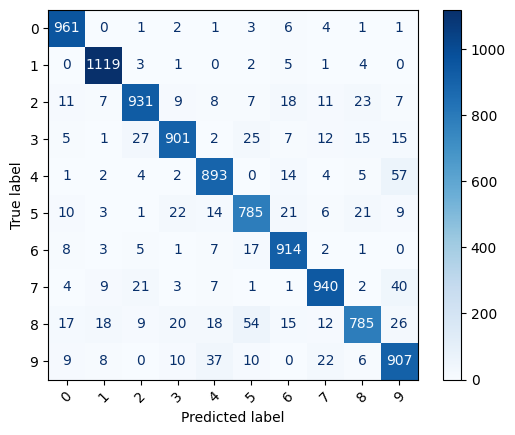

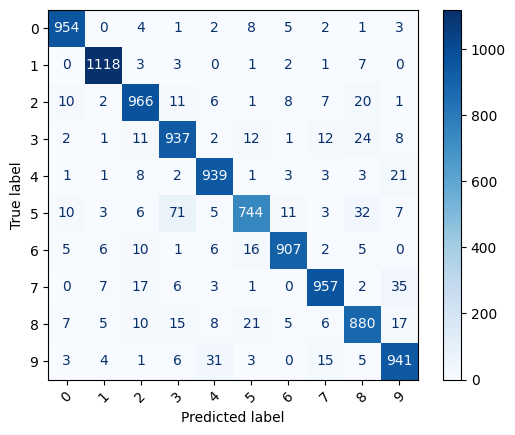

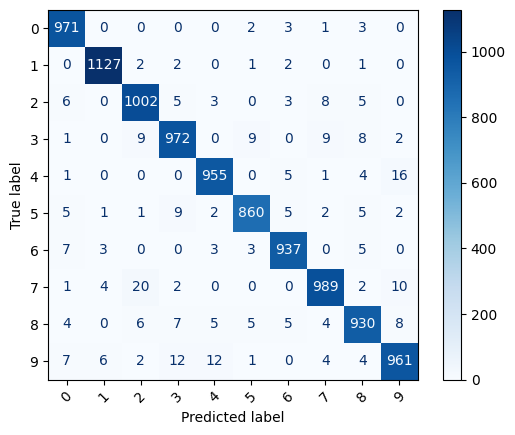

In [5]:
# 5️⃣ Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate(model, X, y, name):
    preds = model.predict(X)
    print(f"=== {name} Classification Report ===")
    print(classification_report(y, preds))
    cm = confusion_matrix(y, preds)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues", xticks_rotation=45)
    return preds, cm

pred_sgd_ovr, cm_ovr = evaluate(sgd_ovr, X_test, y_test, "SGD OvR")
pred_sgd_ovo, cm_ovo = evaluate(sgd_ovo, X_test, y_test, "SGD OvO")
pred_rf, cm_rf = evaluate(rf, X_test, y_test, "Random Forest")


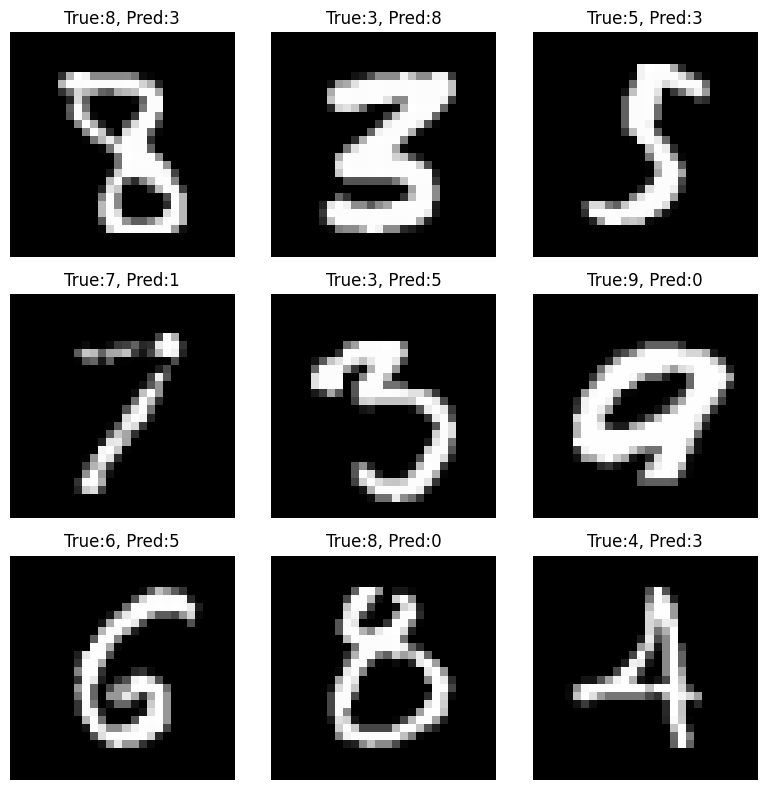

In [6]:
# 6️⃣ Visualize Worst Misclassifications
import numpy as np
import matplotlib.pyplot as plt

def plot_errors(model, X, y_true, preds, n=9):
    errors = np.where(preds != y_true)[0]
    scores = model.predict_proba(X) if hasattr(model, "predict_proba") else None
    chosen = np.random.choice(errors, size=n, replace=False)
    plt.figure(figsize=(8, 8))
    for i, idx in enumerate(chosen):
        img = X.iloc[idx].values.reshape(28, 28)
        plt.subplot(3, 3, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"True:{y_true[idx]}, Pred:{preds[idx]}")
        plt.axis("off")
    plt.tight_layout()

plot_errors(sgd_ovr, X_test, y_test, pred_sgd_ovr)


In [7]:
# 7️⃣ OvR vs OvO Decision Boundary Comparison (optional visual)
print("SGD OvR accuracy:", (pred_sgd_ovr == y_test).mean())
print("SGD OvO accuracy:", (pred_sgd_ovo == y_test).mean())


SGD OvR accuracy: 0.9136
SGD OvO accuracy: 0.9343


In [10]:
import gradio as gr
import numpy as np

def classify_image(image):
    # Preprocess image: resize, flatten, normalize
    image = image.convert("L").resize((28, 28))  # Grayscale & resize
    img_array = np.array(image).reshape(1, -1) / 255.0
    pred = rf.predict(img_array)[0]
    return str(pred)

demo = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil", label="Draw or Upload Digit"),
    outputs=gr.Label(num_top_classes=1, label="Predicted Digit"),
    title="MNIST Digit Recognizer",
    description="Upload or draw a 28x28 grayscale image of a digit."
)

demo.launch()



It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://76956938a1b297b6b1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [9]:
# 9️⃣ Error Analysis Report
# Example: Common misclassifications like 9→4, 7→1, 3→5
from collections import Counter
err_pairs = [(true, pred) for true, pred in zip(y_test, pred_rf) if true != pred]
most_common = Counter(err_pairs).most_common(3)
print("Top 3 common errors:", most_common)

# Propose: Add gaussian noise, rotate images as augmentation
# Implement one improvement now:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

def rotate(X):
    # placeholder augment function
    return X

pipeline = Pipeline([
    ('rotate', FunctionTransformer(rotate)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])
pipeline.fit(X_train, y_train)
print("With augmentation, RF accuracy:",
      pipeline.score(X_test, y_test))


Top 3 common errors: [((7, np.int64(2)), 20), ((4, np.int64(9)), 16), ((9, np.int64(3)), 12)]
With augmentation, RF accuracy: 0.9704
